In [1]:
import h5py, sys, os
import numpy as np
from scipy.special import j1
from scipy.signal import hilbert2
from scipy import ndimage
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyhank import HankelTransform
from matplotlib import colors
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/N_175/512/


In [2]:
#Load simulation data
var1, times = load_data('w_xz')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

tstart_idx = get_index(5, times)
tend_idx = get_index(25, times)
print(tstart_idx, times[tstart_idx])
print(tend_idx, times[tend_idx])

#zplot = 0.4
zmin = 0.3
zmax = 0.5
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)

var1_filtered = np.zeros_like(var1)

for i in range(NSAMP):
    var1_filtered[i] = ndimage.gaussian_filter(var1[i], 1)

waves = var1_filtered[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]

print(var1.shape)
print(waves.shape)


Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Plume penetration occured at t=2.4639
30 5.00000000000001
179 19.900000000000027
(180, 513, 512)
(150, 172, 512)


In [3]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 30.0, 'VERSION': 3.9, 'NU_START_TIME': 10.0, 'SAVE_STATS_DT_FINE': 0.1, 'FINE_RES_TIME': 5.0, 'TIME_LIMIT': 20.0, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 3.0625, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 512, 'Ny': 512, 'Nz': 513, 'Nth': 2}


In [4]:
waves_t = np.fft.fft(waves, axis=0) # time FFT
freq_m = np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
waves_t *= 2 # preserve energy
wavesHT = np.fft.ifft(waves_t, axis=0)
waves_txz = np.fft.fft2(wavesHT) # spatial FFT

wavenumber_z = np.fft.fftfreq(waves.shape[1], d=md['LZ']/md['Nz'])
wavenumber_x = np.fft.fftfreq(waves.shape[2], d=md['LX']/md['Nx'])

waves_right = np.copy(waves_txz)
waves_left = np.copy(waves_txz)

waves_right[:, :, wavenumber_x >= 0] = 0 # isolate rightward moving waves
waves_left[:, :, wavenumber_x <= 0] = 0 # isolate leftward moving waves

waves_right = np.fft.ifft2(waves_right)
waves_left = np.fft.ifft2(waves_left)

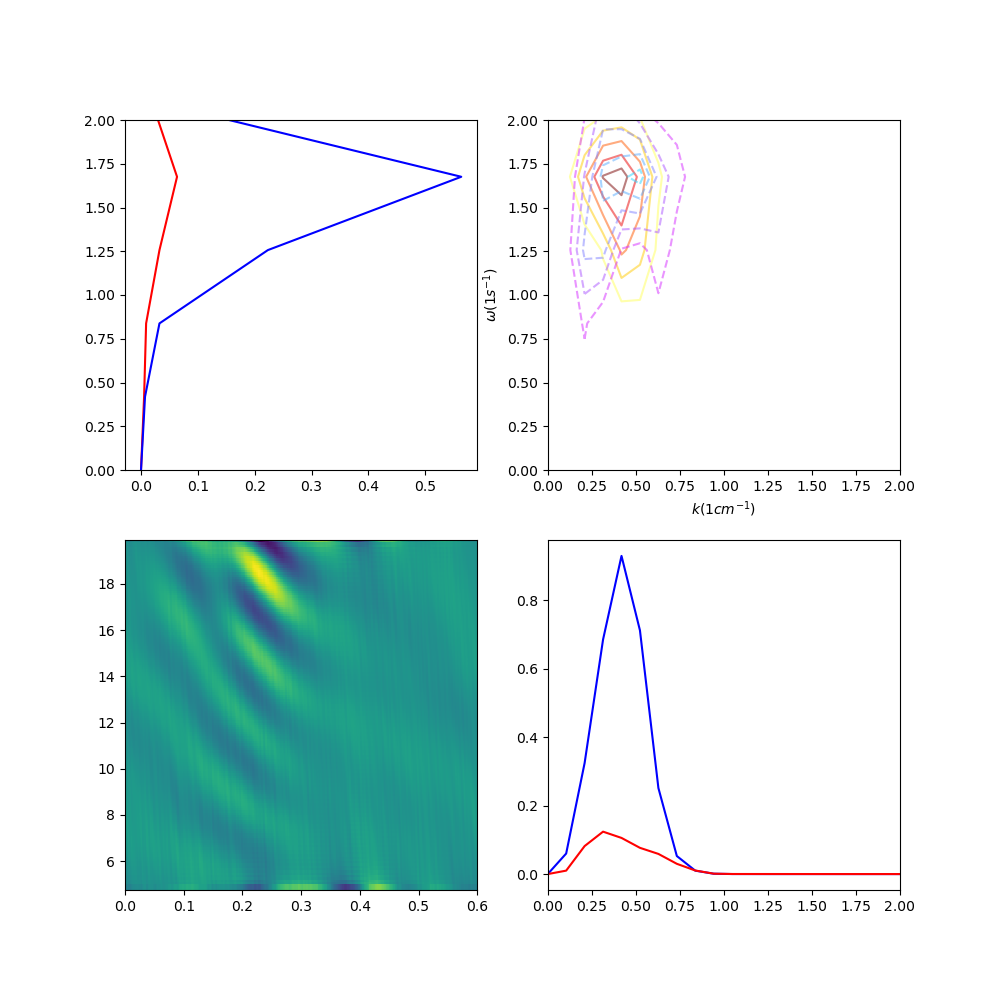

In [5]:
# Plot frequency and wavenumber spectra
zplot = 0.4
gzf_trunc = gzf[zmin_idx:zmax_idx+1]
times_trunc = times[tstart_idx-1:tend_idx+1]

stacked_right = np.real(waves_right[:, get_index(zplot, gzf_trunc), :])
stacked_right = np.flip(stacked_right, axis=0) # flip data
right_ft = np.fft.fft2(stacked_right)
right_ft = np.fft.fftshift(right_ft)

stacked_left = np.real(waves_left[:, get_index(zplot, gzf_trunc), :])
left_ft = np.fft.fft2(stacked_left)
left_ft = np.fft.fftshift(left_ft)

freq = np.fft.fftfreq(stacked_right.shape[0])*2*np.pi/md['SAVE_STATS_DT_FINE']
freq = np.fft.fftshift(freq)
wavenumber = np.fft.fftfreq(stacked_right.shape[1])*2*np.pi*md['Nx']/md['LX']
wavenumber = np.fft.fftshift(wavenumber)

power_r = np.power(np.abs(right_ft), 2)
power_l = np.power(np.abs(left_ft), 2)

X, Y = np.meshgrid(wavenumber/100, freq)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,1].contour(X, Y, power_r, cmap='hot_r', alpha=0.5)
ax[0,1].contour(X, Y, power_l, cmap='cool_r', alpha=0.5, linestyles='--')
ax[0,1].set_xlabel(r"$k (1 cm^{-1})$")
ax[0,1].set_ylabel(r"$\omega (1 s^{-1})$")
ax[0,1].set_xlim(0, 2)
ax[0,1].set_ylim(0, 2)

X, Y = np.meshgrid(gx, times_trunc)
ax[1,0].pcolormesh(X, Y, stacked_left)
#ax[1,0].set_xlim(0, 20)
#ax[1,0].set_ylim(7.5, 25)

ax[0,0].plot(np.mean(power_l, axis=1), freq, color='r')
ax[0,0].plot(np.mean(power_r, axis=1), freq, color='b')
ax[0,0].set_ylim(0, 2)

ax[1,1].plot(wavenumber/100, np.mean(power_r, axis=0), color='b')
ax[1,1].plot(wavenumber/100, np.mean(power_l, axis=0), color='r')
ax[1,1].set_xlim(0, 2)
plt.show()


In [6]:
##### Calculate characteristic frequency #####
omega_c_l = 0
norm_l = 0
omega_c_r = 0
norm_r = 0

N = np.sqrt(md['N2'])

amp2_l = np.mean(power_l, axis=1)
amp2_r = np.mean(power_r, axis=1)

for i in range(len(freq)):
    if freq[i] >= 0:
        norm_l += amp2_l[i]
        omega_c_l += freq[i]*amp2_l[i]
        norm_r += amp2_r[i]
        omega_c_r += freq[i]*amp2_r[i]

omega_c_l /= norm_l
omega_c_r /= norm_r
print(omega_c_l, omega_c_r)
print(omega_c_l/N, omega_c_r/N)

2.022793930014022 1.646648198350645
1.1558822457222981 0.94094182762894


In [7]:
##### Calculate characteristic frequency #####
k_c_l = 0
norm_l = 0
k_c_r = 0
norm_r = 0

N = np.sqrt(md['N2'])

amp2_l = np.mean(power_l, axis=0)
amp2_r = np.mean(power_r, axis=0)

for i in range(len(wavenumber)):
    if wavenumber[i] >= 0:
        norm_l += amp2_l[i]
        k_c_l += wavenumber[i]*amp2_l[i]
        norm_r += amp2_r[i]
        k_c_r += wavenumber[i]*amp2_r[i]

k_c_l /= norm_l
k_c_r /= norm_r
print(k_c_l, k_c_r)

47.21272500788594 42.529344577923176
